# A Time-Dependent Flow Reactor: Periodic Ignition/Extinction

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- How to add time-dependent inflow to a `HomogeneousReactor` model

## Introduction

This demonstration considers a reactor model with a slowly oscillating feed temperature. The frequency of this oscillation is low enough that it triggers repeated ignition/extinction events. Time-dependence is introduced with a Python `lambda` function.

In [2]:
from spitfire import ChemicalMechanismSpec, HomogeneousReactor
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mech = ChemicalMechanismSpec(cantera_input='h2-burke.yaml', group_name='h2-burke')

air = mech.stream(stp_air=True)
fuel = mech.stream('X', 'H2:1')

mix = mech.mix_for_equivalence_ratio(1.0, fuel, air)
mix.TP = 800., 101325.

## Time-dependent Feed Temperature

Unlike reactors in simpler demonstrations, this reactor involves flow (`mass_transfer='open'`), and Spitfire requires the residence time (`mixing_tau`) and feed stream, specified through the `feed_temperature` and `feed_mass_fractions` arguments. Any of these arguments can be functions of time, as shown below for the feed temperature.

Next we simply integrate this reactor over a time period - two periods of oscillation of the feed temperature.

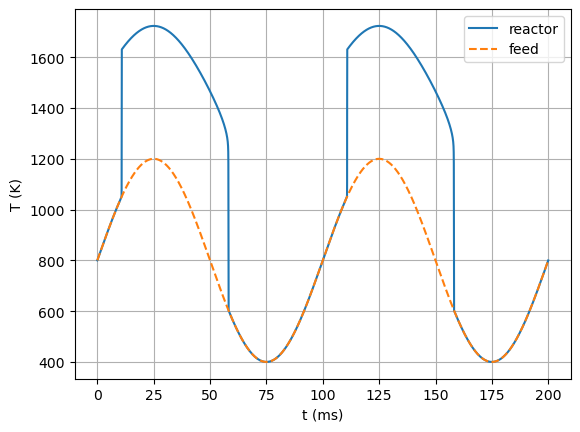

In [4]:
feed = mech.copy_stream(mix)
feed_temperature_fxn = lambda t: 800. + 400. * np.sin(2. * np.pi * 10. * t)

reactor = HomogeneousReactor(mech, mix,
                             configuration='isobaric',
                             heat_transfer='adiabatic',
                             mass_transfer='open',
                             mixing_tau=1.e-5,
                             feed_temperature=feed_temperature_fxn,
                             feed_mass_fractions=feed.Y)

output = reactor.integrate_to_time(0.2, transient_tolerance=1.e-10)

times = output.time_values

plt.plot(times * 1.e3, output['temperature'], '-', label='reactor')
plt.plot(times * 1.e3, feed_temperature_fxn(times), '--', label='feed')

plt.ylabel('T (K)')
plt.xlabel('t (ms)')
plt.legend()
plt.grid()

plt.show()

While it's clear that the reactor ignites on the upswing of the feed temperature, and is extinguished on the downswing, we could also visualize the chemcial composition. The output from the integration is a `Library` object, with a single dimension of time, which we can simply print to see all the fields available.

In [5]:
print(output)


Spitfire Library with 1 dimensions and 13 properties
------------------------------------------
1. Dimension "time" spanning [0.0, 0.2] with 3400 points
------------------------------------------
temperature         , min = 400.0002369336172 max = 1723.4175058596395
pressure            , min = 101325.0 max = 101325.0
mass fraction HE    , min = -1.1102230246251565e-15 max = 7.771561172376096e-16
mass fraction H     , min = 0.0 max = 0.0043260783925692875
mass fraction H2    , min = 0.006811052700193299 max = 0.028635883659904566
mass fraction O     , min = 0.0 max = 0.015190160615859661
mass fraction OH    , min = 0.0 max = 0.01517843114208942
mass fraction H2O   , min = 0.0 max = 0.15018056454013207
mass fraction O2    , min = 0.06530016317137514 max = 0.22725471362837954
mass fraction HO2   , min = 0.0 max = 0.0002942116396534905
mass fraction H2O2  , min = 0.0 max = 5.528673292061469e-06
mass fraction N2    , min = 0.744109402711716 max = 0.744109402711716
mass fraction AR    , min

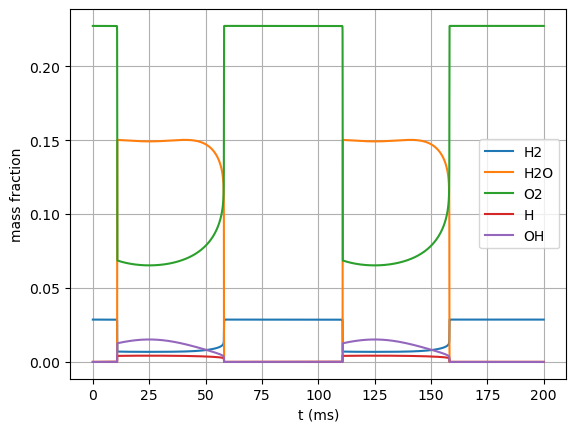

In [6]:
for s in ['H2', 'H2O', 'O2', 'H', 'OH']:
    plt.plot(times * 1.e3, output[f'mass fraction {s}'], label=s)

plt.ylabel('mass fraction')
plt.xlabel('t (ms)')
plt.legend()
plt.grid()

plt.show()

## Conclusions

This notebook shows how to incorporate mass flow in a reactor model and have the temperature of the feed stream vary with time.